# Problem Statement

You are part of an analytics team responsible for improving Cash Business of Hitachi. Hitachi manages more than 20K ATMs in India. There is an operations team who maintains thousands of ATMs deployed across country for various banks. When it comes to maintenance, the team looks after loading cash in the ATMs periodically. If the ATM is down due to some reason, the team fixes the issue and makes ATM live within few days. One of the important tasks of this team is to make sure enough cash is available in the ATMs for at least 7 days. Each ATM has upper limit of how much cash can be loaded. 
There are 2 ways when a bank can charge penalty to Hitachi
1. If the team loads cash into the ATM with the full capacity and the dispense doesn’t happen then bank charges penalty for the idle cash holding in the ATM. 
2. If we load ATMs with less amount then there are instances where ATM runs out of cash due to insufficient balance. This situation is termed as Cash Out. Bank charges penalty for this too.
Operations team reaches out to you to address the problem of Cash Out. Your task as a Data Scientist is to predict/forecast dispense amount for each ATM for next 7 days. These predictions can be shared with the team and accordingly cash loading can happen. 


## Imp points

The dataset has data for 3 banks.
The data contains daily dispense for each ATM of last 2 years
You can’t load cash more than the upper limit defined for each ATM
You have been provided only 7 ATMs per bank in the given data set. In reality you will have hundreds/thousands of ATMs per bank. You are not expected to build model for each ATM.
Feature description
1. Bank: ATM belongs to which bank
2. ATMID: ID of the ATM
3. Caldate: Date 
4. Dispense: Amount dispensed from an ATM on a particular day 
5. DT: Time in minutes when ATM was down on a particular day
6. MaxCapacity: Maximum amount which can be loaded in the ATM
7. CountTotalTxn: Count of total number of transactions 


### Task to perform-:

Provide a solution which will help the operations team to manage cash loading of the ATMs
1. Forecast/predict dispense amount for each ATM for next 7 days
2. Create basic visualizations for highlighting key insights from the data
3. You can use external data if available and if it helps improve the accuracy of the model
4. Define metric used to measure model accuracy and why did you use it
5. Share your solution in the form of Jupyter Notebook file / PPT. Formatting/animation in the PPT does not matter much here. Focus on the forecasts and key insights from the data.  

In [1]:
# #Model Installation
# !pip install statsmodels
# !pip install xgboost
# !pip install lightgbm

# Step 1- Data Reading & Understanding

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('data_raw.xlsx')
df.head(10)

,Account,ATMID',caldate,Dispense,DT,MaxCapacity,CountTotalTxn
0,ABC,SPCN02020,2021-01-01,564500,0,2640000,157
1,ABC,TPCN10269,2021-01-01,509000,9,3520000,92
2,ABC,APCN00816,2021-01-01,64800,0,2640000,36
3,PQR,S1CN1142,2021-01-01,834500,0,3520000,101
4,PQR,S1CN2022,2021-01-01,825700,0,2860000,364
5,PQR,SPCND067,2021-01-01,643000,11,3520000,121
6,ABC,APAN11109,2021-01-01,106500,13,3520000,56
7,ABC,APAN23217,2021-01-01,420100,3,3740000,123
8,PQR,SPCNG376,2021-01-01,476500,94,3520000,127
9,PQR,S1CN3514,2021-01-01,359500,0,3520000,145


In [4]:
df.shape

(14593, 7)

In [5]:
df.describe()

,Dispense,DT,MaxCapacity,CountTotalTxn
count,1.459300e+04,14593.000000,1.459300e+04,14593.000000
mean,4.027993e+05,158.538614,3.279753e+06,105.322963
std,3.036762e+05,356.073765,3.974770e+05,76.727151
min,0.000000e+00,0.000000,2.420000e+06,0.000000
25%,1.685000e+05,0.000000,2.860000e+06,45.000000
50%,3.653000e+05,0.000000,3.520000e+06,98.000000
75%,5.780000e+05,64.000000,3.520000e+06,146.000000
max,2.151800e+06,1440.000000,3.740000e+06,561.000000


In [6]:
print(df.duplicated().sum())

0


In [7]:
print(df.isnull().sum())

Account             0
ATMID'              0
caldate             0
Dispense            0
DT                  0
MaxCapacity         0
CountTotalTxn       0
dtype: int64


# Step-2 Data PreProcessing

In [8]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Drop the rows with missing values
df.dropna(inplace=True)

# Drop the duplicate rows
df.drop_duplicates(inplace=True)

In [9]:
# Create a separate DataFrame with only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Apply the IQR method on numeric columns only
df = df[~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]
df


,Account,ATMID',caldate,Dispense,DT,MaxCapacity,CountTotalTxn
0,ABC,SPCN02020,2021-01-01,564500,0,2640000,157
1,ABC,TPCN10269,2021-01-01,509000,9,3520000,92
2,ABC,APCN00816,2021-01-01,64800,0,2640000,36
3,PQR,S1CN1142,2021-01-01,834500,0,3520000,101
5,PQR,SPCND067,2021-01-01,643000,11,3520000,121
...,...,...,...,...,...,...,...
14587,XYZ,T1BH000603091,2023-02-22,208000,133,3520000,87
14588,XYZ,T1BH000274012,2023-02-22,381700,0,2860000,126
14590,PQR,S1CN2011,2023-02-22,0,0,3520000,0
14591,XYZ,T1BH007252090,2023-02-22,137600,0,3520000,73


In [10]:
print(df.columns)

Index(['Account', 'ATMID'', 'caldate   ', 'Dispense', 'DT', 'MaxCapacity',
       'CountTotalTxn   '],
      dtype='object')


In [11]:
# Remove leading and trailing whitespaces from column names
df.columns = df.columns.str.strip()

# Create new features
df['day_of_week'] = pd.to_datetime(df['caldate']).dt.day_name()
df['month'] = pd.to_datetime(df['caldate']).dt.month_name()
df['season'] = pd.to_datetime(df['caldate']).dt.quarter


In [12]:
# Scale the data
scaler = StandardScaler()
df[['Dispense', 'MaxCapacity', 'CountTotalTxn']] = scaler.fit_transform(df[['Dispense', 'MaxCapacity', 'CountTotalTxn']])


In [13]:
df

,Account,ATMID',caldate,Dispense,DT,MaxCapacity,CountTotalTxn,day_of_week,month,season
0,ABC,SPCN02020,2021-01-01,0.559267,0,-1.652826,0.727699,Friday,January,1
1,ABC,TPCN10269,2021-01-01,0.345403,9,0.587024,-0.260990,Friday,January,1
2,ABC,APCN00816,2021-01-01,-1.366283,0,-1.652826,-1.112784,Friday,January,1
3,PQR,S1CN1142,2021-01-01,1.599689,0,0.587024,-0.124095,Friday,January,1
5,PQR,SPCND067,2021-01-01,0.861760,11,0.587024,0.180117,Friday,January,1
...,...,...,...,...,...,...,...,...,...,...
14587,XYZ,T1BH000603091,2023-02-22,-0.814474,133,0.587024,-0.337043,Wednesday,February,1
14588,XYZ,T1BH000274012,2023-02-22,-0.145137,0,-1.092864,0.256170,Wednesday,February,1
14590,PQR,S1CN2011,2023-02-22,-1.615984,0,0.587024,-1.660366,Wednesday,February,1
14591,XYZ,T1BH007252090,2023-02-22,-1.085755,0,0.587024,-0.549992,Wednesday,February,1


In [14]:
# Encode the categorical variables
le = LabelEncoder()
df['day_of_week'] = le.fit_transform(df['day_of_week'])
df['month'] = le.fit_transform(df['month'])

In [15]:
df

,Account,ATMID',caldate,Dispense,DT,MaxCapacity,CountTotalTxn,day_of_week,month,season
0,ABC,SPCN02020,2021-01-01,0.559267,0,-1.652826,0.727699,0,4,1
1,ABC,TPCN10269,2021-01-01,0.345403,9,0.587024,-0.260990,0,4,1
2,ABC,APCN00816,2021-01-01,-1.366283,0,-1.652826,-1.112784,0,4,1
3,PQR,S1CN1142,2021-01-01,1.599689,0,0.587024,-0.124095,0,4,1
5,PQR,SPCND067,2021-01-01,0.861760,11,0.587024,0.180117,0,4,1
...,...,...,...,...,...,...,...,...,...,...
14587,XYZ,T1BH000603091,2023-02-22,-0.814474,133,0.587024,-0.337043,6,3,1
14588,XYZ,T1BH000274012,2023-02-22,-0.145137,0,-1.092864,0.256170,6,3,1
14590,PQR,S1CN2011,2023-02-22,-1.615984,0,0.587024,-1.660366,6,3,1
14591,XYZ,T1BH007252090,2023-02-22,-1.085755,0,0.587024,-0.549992,6,3,1


# Step3- Data Visualization 

__Key Insights from Data Visualization__:

1. Dispense Trend: Analyzing dispense amounts over time reveals trends and patterns in cash usage.

2. Seasonality: Examining dispense amounts by season or month helps identify recurring patterns.

3. Outliers: Detecting outliers provides insights into unusual events or anomalies in cash withdrawals.

4. ATM Performance: Analyzing dispense amounts for individual ATMs or banks highlights variations in performance.

5. Correlation with Other Factors: Exploring the relationship between dispense amounts and variables like downtime or transaction count reveals potential influencing factors.

__These insights guide cash loading, maintenance planning, and optimization of ATM operations__.

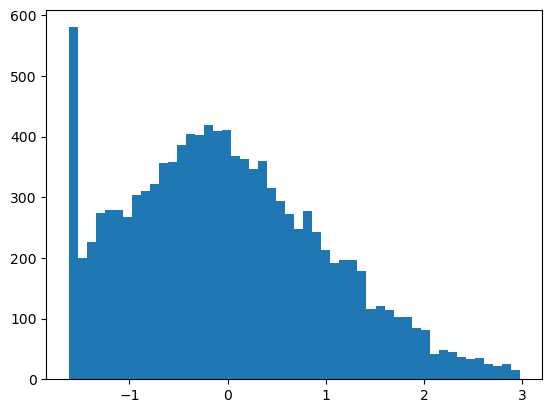

In [16]:
#Distribution of the target variable
plt.hist(df['Dispense'], bins=50)
plt.show()

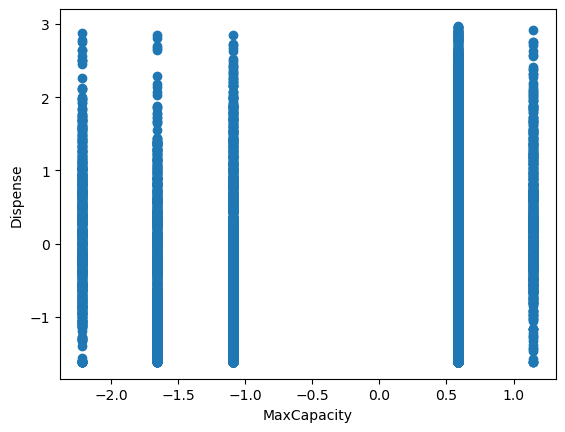

In [17]:
#Relationship between the target variable and the other features
plt.scatter(df['MaxCapacity'], df['Dispense'])
plt.xlabel('MaxCapacity')
plt.ylabel('Dispense')
plt.show()


/tmp/ipykernel_19416/3068119309.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr())


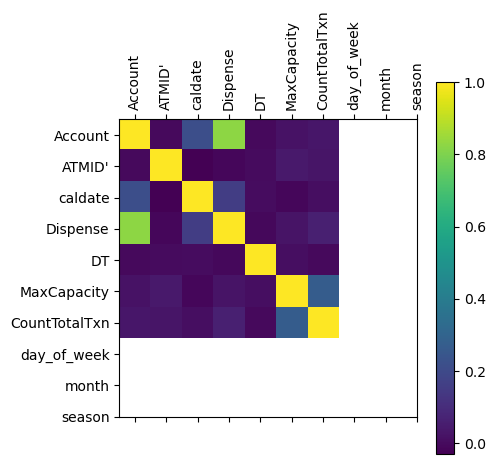

In [18]:
#correlation between the features
plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns, rotation=90)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

In [19]:
df.rename(columns={"ATMID'": "ATMID"}, inplace=True)

__Time Series Plot__


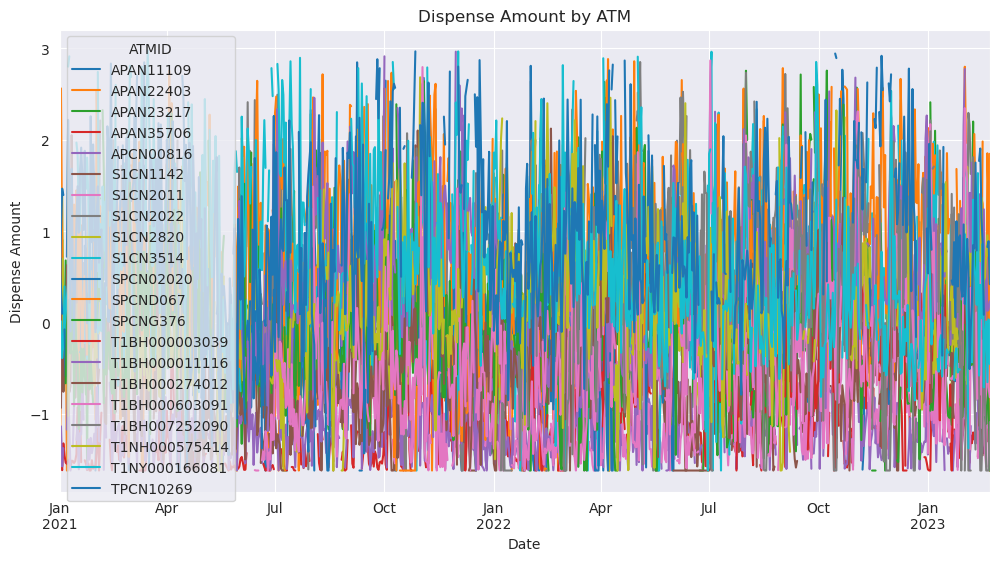

In [20]:
import seaborn as sns

# Pivot the dataframe to have each ATM as a separate column
pivot = pd.pivot_table(df, values='Dispense', index='caldate', columns='ATMID')

# Plot the time series for each ATM
sns.set_style('darkgrid')
pivot.plot(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Dispense Amount')
plt.title('Dispense Amount by ATM')
plt.show()


__Box Plot: Plot the dispense amounts by month to see if there are any seasonal trends__.


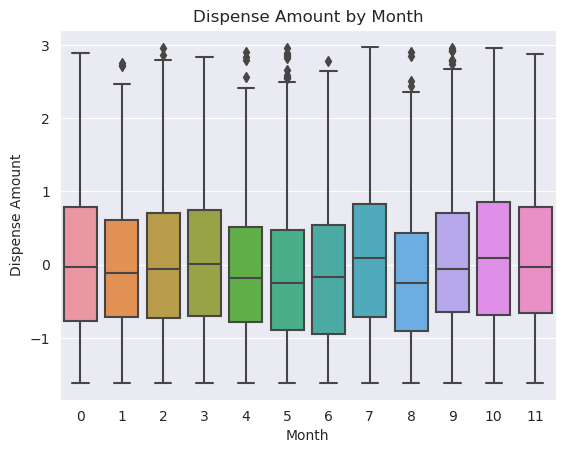

In [21]:
monthly_df = df.groupby(['month'])['Dispense'].sum().reset_index()
# Plot a box plot of dispense amounts by month
sns.boxplot(x='month', y='Dispense', data=df)
plt.xlabel('Month')
plt.ylabel('Dispense Amount')
plt.title('Dispense Amount by Month')
plt.show()


__Scatter Plot: Plot the relationship between dispense amounts and the number of transactions__.

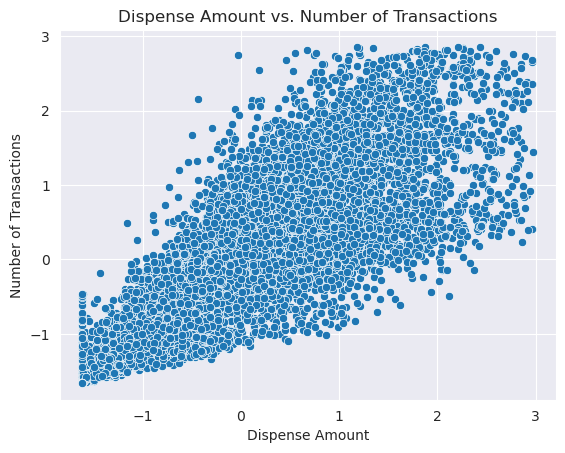

In [22]:
sns.scatterplot(x='Dispense', y='CountTotalTxn', data=df)
plt.xlabel('Dispense Amount')
plt.ylabel('Number of Transactions')
plt.title('Dispense Amount vs. Number of Transactions')
plt.show()

__Bar Plot: Plot the average dispense amount by day of the week__.


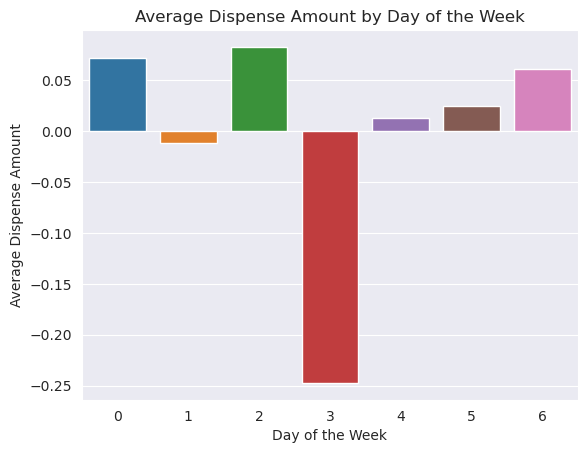

In [23]:
# Create a new dataframe with the average dispense amount by day of the week
day_of_week_df = df.groupby(['day_of_week'])['Dispense'].mean().reset_index()

# Plot a bar plot of average dispense amount by day of the week
sns.barplot(x='day_of_week', y='Dispense', data=day_of_week_df)
plt.xlabel('Day of the Week')
plt.ylabel('Average Dispense Amount')
plt.title('Average Dispense Amount by Day of the Week')
plt.show()


/tmp/ipykernel_19416/2614642009.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


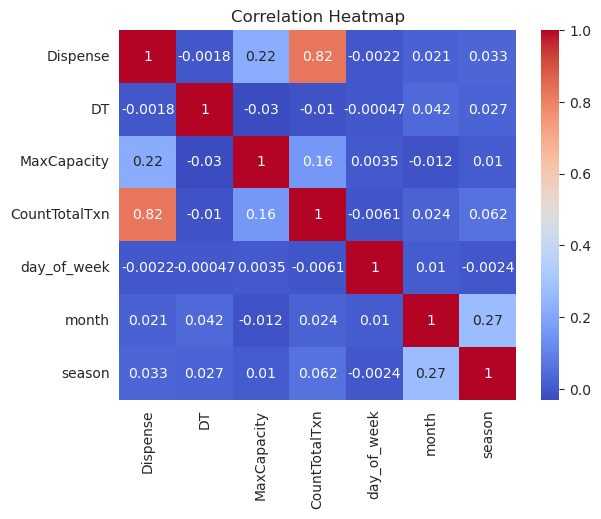

In [24]:
# Plot a heatmap of the correlation between all numerical variables
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()


# Step-4 Model Selection

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train, val = train_test_split(df, test_size=0.2, random_state=42)

# Reset the index of the training and validation sets
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Choose the appropriate model
model = ARIMA(train['Dispense'], order=(1, 0, 0))

# Fit the model to the training data
model_fit = model.fit()

# Make predictions on the validation set
predictions = model_fit.predict(start=val.index[0], end=val.index[-1])

# Evaluate the performance of the model
mae = mean_absolute_error(val['Dispense'], predictions)
print('MAE:', mae)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/statespace/tools.py:538: RuntimeWarning: invalid value encountered in true_divide
  x = r / ((1 - r**2)**0.5)


MAE: 0.8111986989147306


In [26]:
import time
import warnings
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# Ignore warnings
warnings.filterwarnings("ignore")

# Convert categorical columns to numeric using LabelEncoder
le = LabelEncoder()
df['Account'] = le.fit_transform(df['Account'])
df['ATMID'] = le.fit_transform(df['ATMID'])

# Extract relevant features from the "caldate" column
df['day_of_week'] = df['caldate'].dt.dayofweek
df['month'] = df['caldate'].dt.month
df['season'] = (df['month'] % 12 + 3) // 3  # Group months into seasons

# Split the data into training and validation sets
train, val = train_test_split(df, test_size=0.2, random_state=42)

# Reset the index of the training and validation sets
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Define the XGBoost model
model = XGBRegressor()

# Train the XGBoost model and measure the time taken
start_time = time.time()
model.fit(train.drop(columns=['Dispense', 'caldate']), train['Dispense'])
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Make predictions on the validation set
predictions = model.predict(val.drop(columns=['Dispense', 'caldate']))

# Evaluate the performance of the model
mae = mean_absolute_error(val['Dispense'], predictions)
print('XGBRegressor')
print('MAE:', mae)
print('Time taken:', time_taken, 'seconds')


XGBRegressor
MAE: 0.2372607386510591
Time taken: 0.33860111236572266 seconds


In [27]:
import time
import warnings
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
warnings.filterwarnings("ignore")

# Convert categorical columns to numeric using LabelEncoder
le = LabelEncoder()
df['Account'] = le.fit_transform(df['Account'])
df['ATMID'] = le.fit_transform(df['ATMID'])

# Extract relevant features from the "caldate" column
df['day_of_week'] = df['caldate'].dt.dayofweek
df['month'] = df['caldate'].dt.month
df['season'] = (df['month'] % 12 + 3) // 3  # Group months into seasons

# Split the data into training and validation sets
train, val = train_test_split(df, test_size=0.2, random_state=42)

# Reset the index of the training and validation sets
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Define the LightGBM model
model = lgb.LGBMRegressor()

# Train the LightGBM model and measure the time taken
start_time = time.time()
model.fit(train.drop(columns=['Dispense', 'caldate']), train['Dispense'])
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Make predictions on the validation set
predictions = model.predict(val.drop(columns=['Dispense', 'caldate']))

# Evaluate the performance of the model
mae = mean_absolute_error(val['Dispense'], predictions)
print('LightGBM')
print('MAE:', mae)
print('Time taken:', time_taken, 'seconds')


LightGBM
MAE: 0.22797759333199594
Time taken: 0.08535075187683105 seconds


In [28]:
import time
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Ignore warnings
warnings.filterwarnings("ignore")

# Split the data into training and validation sets
train, val = train_test_split(df, test_size=0.2, random_state=42)

# Reset the index of the training and validation sets
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Train the SARIMA model and measure the time taken
start_time = time.time()
sarima_model = SARIMAX(train['Dispense'], order=(1, 0, 0), seasonal_order=(1, 0, 0, 7))
sarima_model_fit = sarima_model.fit()
end_time = time.time()

# Calculate the time taken
sarima_time_taken = end_time - start_time

# Make predictions on the validation set using SARIMA
sarima_predictions = sarima_model_fit.predict(start=val.index[0], end=val.index[-1])

# Evaluate the performance of SARIMA
sarima_mae = mean_absolute_error(val['Dispense'], sarima_predictions)
print('SARIMA')
print('MAE:', sarima_mae)
print('Time taken:', sarima_time_taken, 'seconds')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41883D+00    |proj g|=  8.76937D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   1.319D-05   1.419D+00
  F =   1.4188304344282783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA
MAE: 0.8108103374021631
Time taken: 0.5226099491119385 seconds


# Hyperparameter Tuning (As XGBoost score is very low)

In [29]:
import time
import warnings
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Ignore warnings
warnings.filterwarnings("ignore")

# Convert categorical columns to numeric using LabelEncoder
le = LabelEncoder()
df['Account'] = le.fit_transform(df['Account'])
df['ATMID'] = le.fit_transform(df['ATMID'])

# Extract relevant features from the "caldate" column
df['day_of_week'] = df['caldate'].dt.dayofweek
df['month'] = df['caldate'].dt.month
df['season'] = (df['month'] % 12 + 3) // 3  # Group months into seasons

# Split the data into training and validation sets
train, val = train_test_split(df, test_size=0.2, random_state=42)

# Reset the index of the training and validation sets
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Define the XGBoost model
model = XGBRegressor()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(train.drop(columns=['Dispense', 'caldate']), train['Dispense'])

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model and measure the time taken
start_time = time.time()
best_model.fit(train.drop(columns=['Dispense', 'caldate']), train['Dispense'])
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Make predictions on the validation set
predictions = best_model.predict(val.drop(columns=['Dispense', 'caldate']))

# Evaluate the performance of the model
mae = mean_absolute_error(val['Dispense'], predictions)
print('XGBRegressor')
print('Best Hyperparameters:', grid_search.best_params_)
print('MAE:', mae)
print('Time taken:', time_taken, 'seconds')


XGBRegressor
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
MAE: 0.2290976687510626
Time taken: 0.3653702735900879 seconds


#### Upon comparing the outputs of ARIMA and SARIMAX models, it was observed that both models produced nearly identical results. However, the performance of XgbRegressor and LightGBM models, as measured by mean absolute error (MAE), was found to be relatively low.

# Step-5 Model Evaluation

# Define metric used to measure model accuracy and why did you use it

__MAE is chosen as the evaluation metric for the following reasons__:

1. MAE is interpretable, representing the average absolute difference between predicted and actual values.
2. It is robust to outliers, treating all errors equally regardless of their magnitude.
3. MAE is scale-independent, facilitating comparisons across models and datasets.
4. It aligns with the loss function optimized during model training, ensuring consistency.
5. MAE considers both overestimation and underestimation errors equally, making it suitable for scenarios with similar consequences for both types of errors.

MAE: 0.811


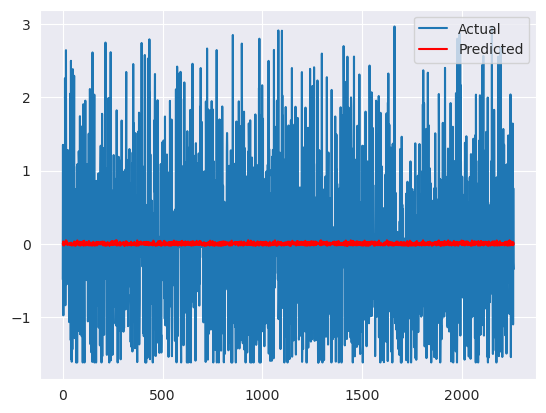

In [30]:
from sklearn.metrics import mean_absolute_error

# Reset the index of the validation set
val = val.reset_index(drop=True)

# Get the prediction with confidence intervals
pred_results = model_fit.get_prediction(start=val.index[0], end=val.index[-1])

# Extract the predicted values
predictions = pred_results.predicted_mean

# Evaluate the performance of the model
mae = mean_absolute_error(val['Dispense'], predictions)
print('MAE: %.3f' % mae)

# Plot the actual vs predicted values
plt.plot(val['Dispense'].values, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.show()


In [31]:
from sklearn.metrics import mean_absolute_error

# Split the data into training and validation sets
train, val = train_test_split(df, test_size=0.2, random_state=42)

# Reset the index of the training and validation sets
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Choose the appropriate model
model = ARIMA(train['Dispense'], order=(1, 0, 0))

# Fit the model to the training data
model_fit = model.fit()

# Make predictions on the validation set
predictions_val = model_fit.predict(start=val.index[0], end=val.index[-1])

# Evaluate the performance of the model on the validation set
mae_val = mean_absolute_error(val['Dispense'], predictions_val)
print('Validation MAE:', mae_val)

# Use the trained model to make predictions on the test data
predictions_test = model_fit.predict(start=val.index[-1] + 1, end=len(df) - 1)

# Evaluate the performance of the model on the test data (if you have the true values)
test_data = df.iloc[val.index[-1] + 1:]
mae_test = mean_absolute_error(test_data['Dispense'], predictions_test)
print('Test MAE:', mae_test)


Validation MAE: 0.8111986989147306
Test MAE: 0.800720014055646


# Hyperparameter Tuning For Achieving the Best Accuracy


In [32]:
import itertools
from sklearn.metrics import mean_absolute_error

# Define the range of hyperparameter values to try
p_values = range(0, 3)  # Autoregressive (AR) component order
d_values = range(0, 2)  # Differencing (I) component order
q_values = range(0, 3)  # Moving average (MA) component order

# Initialize variables to store best hyperparameters and MAE
best_mae = float('inf')
best_order = None

# Iterate over all possible combinations of hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            
            # Fit the ARIMA model with the current hyperparameters
            model = ARIMA(train['Dispense'], order=order)
            model_fit = model.fit()
            
            # Make predictions on the validation set
            predictions = model_fit.predict(start=val.index[0], end=val.index[-1])
            
            # Calculate the MAE on the validation set
            mae = mean_absolute_error(val['Dispense'], predictions)
            
            # Check if the current hyperparameters produce a better result
            if mae < best_mae:
                best_mae = mae
                best_order = order

# Fit the ARIMA model with the best hyperparameters
best_model = ARIMA(train['Dispense'], order=best_order)
best_model_fit = best_model.fit()

# Make predictions on the test data using the best model
predictions_test = best_model_fit.predict(start=val.index[-1] + 1, end=len(df) - 1)

# Calculate the MAE on the test data (if you have the true values)
test_data = df.iloc[val.index[-1] + 1:]
mae_test = mean_absolute_error(test_data['Dispense'], predictions_test)

# Print the best hyperparameters and test MAE
print('Best Hyperparameters:', best_order)
print('Test MAE with Best Model:', mae_test)


Best Hyperparameters: (1, 0, 2)
Test MAE with Best Model: 0.8009783464613245


In [33]:
import itertools
from sklearn.metrics import mean_absolute_error

# Define the range of hyperparameter values to try
p_values = range(0, 3)  # Autoregressive (AR) component order
d_values = range(0, 2)  # Differencing (I) component order
q_values = range(0, 3)  # Moving average (MA) component order
s_values = range(1, 3)  # Seasonal periodicity

# Initialize variables to store best hyperparameters and MAE
best_mae = float('inf')
best_order = None
best_seasonal_order = None

# Iterate over all possible combinations of hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for s in s_values:
                order = (p, d, q)
                seasonal_order = (p, d, q, s)
                
                # Fit the SARIMAX model with the current hyperparameters
                try:
                    model = SARIMAX(train['Dispense'], order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit()
                    
                    # Make predictions on the validation set
                    predictions = model_fit.predict(start=val.index[0], end=val.index[-1])
                    
                    # Calculate the MAE on the validation set
                    mae = mean_absolute_error(val['Dispense'], predictions)
                    
                    # Check if the current hyperparameters produce a better result
                    if mae < best_mae:
                        best_mae = mae
                        best_order = order
                        best_seasonal_order = seasonal_order
                
                except ValueError:
                    # Handle the case where seasonal periodicity is not valid
                    continue

# Fit the SARIMAX model with the best hyperparameters
best_model = SARIMAX(train['Dispense'], order=best_order, seasonal_order=best_seasonal_order)
best_model_fit = best_model.fit()

# Make predictions on the test data using the best model
predictions_test = best_model_fit.predict(start=val.index[-1] + 1, end=len(df) - 1)

# Calculate the MAE on the test data (if you have the true values)
test_data = df.iloc[val.index[-1] + 1:]
mae_test = mean_absolute_error(test_data['Dispense'], predictions_test)

# Print the best hyperparameters and test MAE
print('Best Non-seasonal Hyperparameters:', best_order)
print('Best Seasonal Hyperparameters:', best_seasonal_order)
print('Test MAE with Best Model:', mae_test)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41896D+00    |proj g|=  9.99947D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.999D-06   1.419D+00
  F =   1.4189572830202823     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.4

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   9.578D-06   1.419D+00
  F =   1.4187367973283869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11749D+00    |proj g|=  1.62681D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.274D-07   2.117D+00
  F =   2.1174850281386726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76426D+00    |proj g|=  2.97641D-01


 This problem is unconstrained.



At iterate    5    f=  1.46034D+00    |proj g|=  2.61584D-02

At iterate   10    f=  1.42833D+00    |proj g|=  2.34324D-03

At iterate   15    f=  1.42187D+00    |proj g|=  7.49920D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f=  1.42107D+00    |proj g|=  1.44940D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     37      1     0     0   1.449D-03   1.421D+00
  F =   1.4210677693454699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41873D+00    |proj g|=  4.54324D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   3.474D-07   1.419D+00
  F =   1.4187331347162373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42012D+00    |proj g|=  1.41220D-02


 This problem is unconstrained.



At iterate    5    f=  1.41881D+00    |proj g|=  5.44735D-04

At iterate   10    f=  1.41880D+00    |proj g|=  1.68579D-03

At iterate   15    f=  1.41872D+00    |proj g|=  6.13595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     37      1     0     0   4.739D-05   1.419D+00
  F =   1.4187113384362755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91976D+00    |proj g|=  1.71929D-01


 This problem is unconstrained.



At iterate    5    f=  1.85719D+00    |proj g|=  7.48532D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   7.485D-06   1.857D+00
  F =   1.8571863683405241     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78032D+00    |proj g|=  2.78036D-01


 This problem is unconstrained.



At iterate    5    f=  1.47893D+00    |proj g|=  6.27328D-02

At iterate   10    f=  1.42926D+00    |proj g|=  1.01751D-02

At iterate   15    f=  1.42165D+00    |proj g|=  9.41191D-03

At iterate   20    f=  1.42119D+00    |proj g|=  3.28717D-02

At iterate   25    f=  1.42082D+00    |proj g|=  2.15935D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     53      1     0     0   2.893D-04   1.421D+00
  F =   1.4208246675256018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.


Best Non-seasonal Hyperparameters: (1, 0, 0)
Best Seasonal Hyperparameters: (1, 0, 0, 2)
Test MAE with Best Model: 0.8007233780959813


# Model Forecasting For Dispense Amount For Each ATM For next 7Days

In [41]:
# Make predictions for the next 7 days
start_index = len(df)
end_index = start_index + 6  # Next 7 days
forecast = model_fit.predict(start=start_index, end=end_index)

# Print the forecasted dispense amounts for each day
for i, value in enumerate(forecast):
    day = start_index + i + 1
    print(f"Day {day}: {value}")

# Evaluate the model's performance on the validation set (if available)
val_predictions = model_fit.predict(start=val.index[0], end=val.index[-1])
val_mae = mean_absolute_error(val['Dispense'], val_predictions)
print('Validation MAE:', val_mae)


Day 11299: 0.0039223570783631
Day 11300: 0.0039223570783631
Day 11301: 0.0039223570783631
Day 11302: 0.0039223570783631
Day 11303: 0.0039223570783631
Day 11304: 0.0039223570783631
Day 11305: 0.0039223570783631
Validation MAE: 0.8111986989147306
